# Basic Iterative Method

Add a brief description here

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

## 1. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [3]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 2. Attack

Add some nicer explanation here...
BIM requires the following function, which clips pixel values of an image $X^\prime$:

For the implementation we do for the number of iterations `n`:


a) Compute $ X^\prime = \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true}))$ as used in equation (2.1)

b) Compute $ X(x, y, z) + \epsilon $ and $ X(x, y, z) - \epsilon $

c) Evaluate equation (2.2) using steps a) and b)

$max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \}$ (?)

d) Retrieve updated adversarial image $\widetilde{X}_{1}$ as given in equation (2.1)

Values for the hyper parameters given in [2]:

- $\alpha = 1$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

In [92]:
def apply_BIM(image, label, alpha, epsilon, num_iterations=2):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    model          -- Model under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    label          -- Label from image as tensor of shape (1)
    alpha          -- Hyperparameter for iterative step
    epsilon        -- Hyperparameter for sign method
    num_iterations -- Number of iterations to perform
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''

    ## Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 224, 224]))
    assert(label.shape == torch.Size([1]))
    
    ## Initialize adversarial image as image according to equation (3)
    image_adver = image.clone()    
    
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    #assert(torch.equal(image_plus, image) == False)
    
    for i in range(num_iterations):
        
        ## Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        ## Compute cost with example image_adversarial        
        pred = model(image_adver)        
        loss = F.nll_loss(pred, label)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        
        ## Check if gradient exists
        assert(image_adver.grad is not None)
               
        ## Compute X_prime according to equation (1)
        image_prime = image_adver + alpha * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
    
        
        # Equation 1.2
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation (2)
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver)                        

    
    return image_adver

In [99]:
def compare_examples_bim(alpha, epsilon, idx):
    '''
    Generates an example using BIM. Prints infos and plots clean and adversarial image side-by-side.
    
    Inputs:
    epsilon -- Hyperparameter for BIM
    alpha   -- Hyperparameter for BIM
    idx     -- Index of sample   
    '''
    
    #num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    num_iterations = 4
    print("Number of iterations: " + str(num_iterations))
    
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)

    image_adv = apply_BIM(image_clean, target_label, alpha, epsilon, num_iterations=num_iterations)

    ## Predictions
    _, _, _, conf_clean, label_clean = predict(model, image_clean, target_label)
    _, _, _, conf_adv, label_adv = predict(model, image_adv, target_label)

    ## Plot
    plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_label)

In [14]:
predict?

In [100]:
def get_confidence_acc_class(epsilon, idx):
    '''
    ...
    
    Inputs:
    epsilon -- Hyperparameter for BIM
    idx     -- Index of sample   
    '''
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)
    image_clean = image_clean
    target_label = target_label

    ## Predict clean example
    gradient, _, _, _, label = predict(model, image_clean, target_label, return_grad=True)

    ## Compute adversarial image and predict for it.
    alpha = 1
    #num_iterations = int(np.ceil(np.min([4+epsilon, 1.25*epsilon])))
    num_iterations = 4
    label = torch.tensor(label)
    label.unsqueeze_(0)
    image_adv = apply_BIM(image_clean, label, alpha, epsilon, num_iterations)

    _, acc, _, conf_adv, class_index = predict(model, image_adv, target_label, return_grad=False)
    label_adv = idx_to_name(class_index)
    
    return conf_adv, acc, label_adv

### 2.1 Individual Images

Do some cool analysis here. In particularm find one of the examples where a wrong class is predicted with high confidence. Apparently there aren't neccessarily that many in the ImageNet dataset?

In [101]:
def iterate_epsilons(idx):
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255, 3/255, 4/255, 5/255, 
                6/255, 8/255, 10/255, 12/255, 14/255, 16/255, 18/255, 22/255, 26/255, 32/255, 40/255]


    conf_list = []
    acc_list = []

    print("Epsilon \t Accuracy \t Confidence \t Label")

    for epsilon in epsilons:
        conf_adv, acc, predicted_label = get_confidence_acc_class(epsilon, idx)
        conf_list.append(conf_adv)
        acc_list.append(acc)
        print(str(epsilon*255) + "\t\t\t" + str(acc) + "\t" + str(conf_adv) + "\t" + predicted_label)

    plt.plot(np.array(epsilons)*255, conf_list, color='navy', label='Confidence')
    plt.plot(np.array(epsilons)*255, acc_list, color='orange', label='Accuracy')
    plt.legend()
    plt.show()

Number of iterations: 4
			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			barrel, cask
Confidence: 		99.99%				32.49%



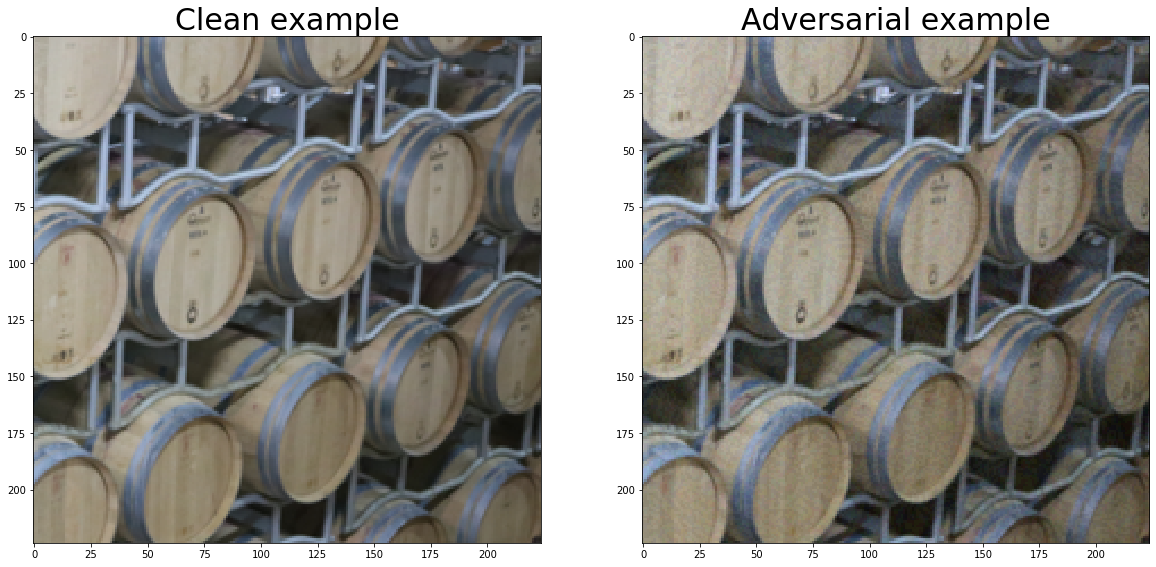

In [96]:
idx = 766
epsilon = 4/255 ## 
alpha = 1 # As in the paper

compare_examples_bim(alpha, epsilon, idx)

Number of iterations: 1
1
			Clean image	 Adversarial image

Actual class: 		baseball			baseball
Predicted class: 	baseball			baseball
Confidence: 		99.79%				14.43%



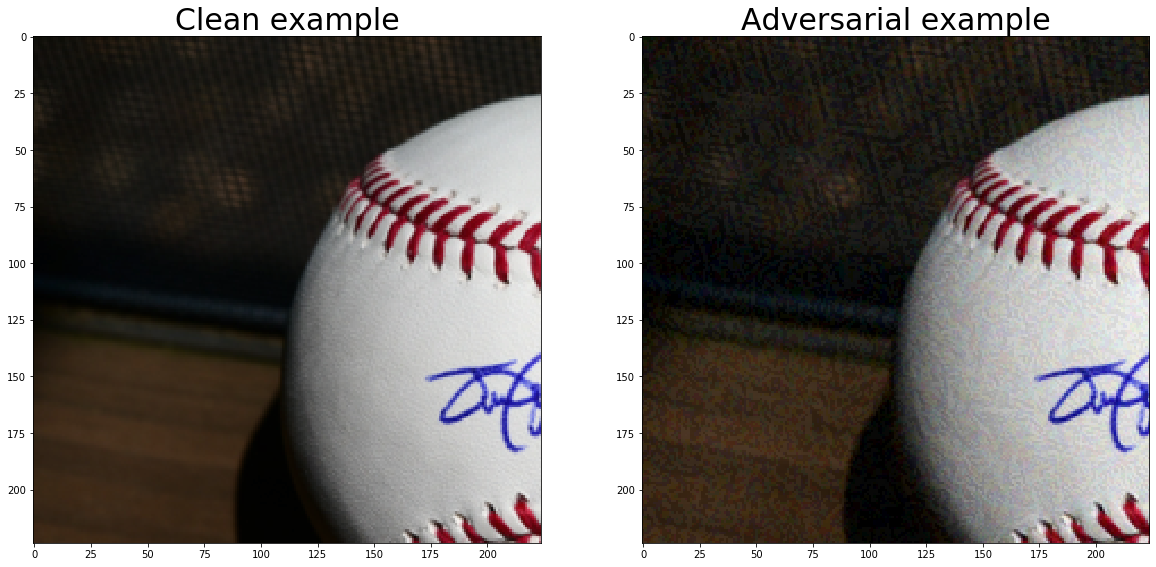

In [70]:
idx = 241
epsilon = 6/255 ## 
alpha = 1 # As in the paper

compare_examples_bim(alpha, epsilon, idx)

Add some results here...

## Highest confidence

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.999767	barrel, cask
0.2			1	0.99909234	barrel, cask
0.3			1	0.99703383	barrel, cask
0.4			1	0.99310356	barrel, cask
0.5			1	0.98853755	barrel, cask
0.7			1	0.97121596	barrel, cask
1.0			1	0.9499181	barrel, cask
2.0			1	0.9599582	barrel, cask
3.0			1	0.9892208	barrel, cask
4.0			1	0.9529559	barrel, cask
5.0			1	0.83578336	barrel, cask
6.0			1	0.8285601	barrel, cask
8.0			1	0.7247472	barrel, cask
10.0			1	0.47900546	barrel, cask
12.0			1	0.72902167	barrel, cask
14.0			1	0.52684313	barrel, cask
16.0			0	0.21468204	lumbermill, sawmill
18.0			0	0.124735184	lumbermill, sawmill
22.0			0	0.13377748	lumbermill, sawmill
26.0			0	0.28896436	honeycomb
32.0			0	0.81656784	honeycomb
40.0			0	0.53247404	brain coral


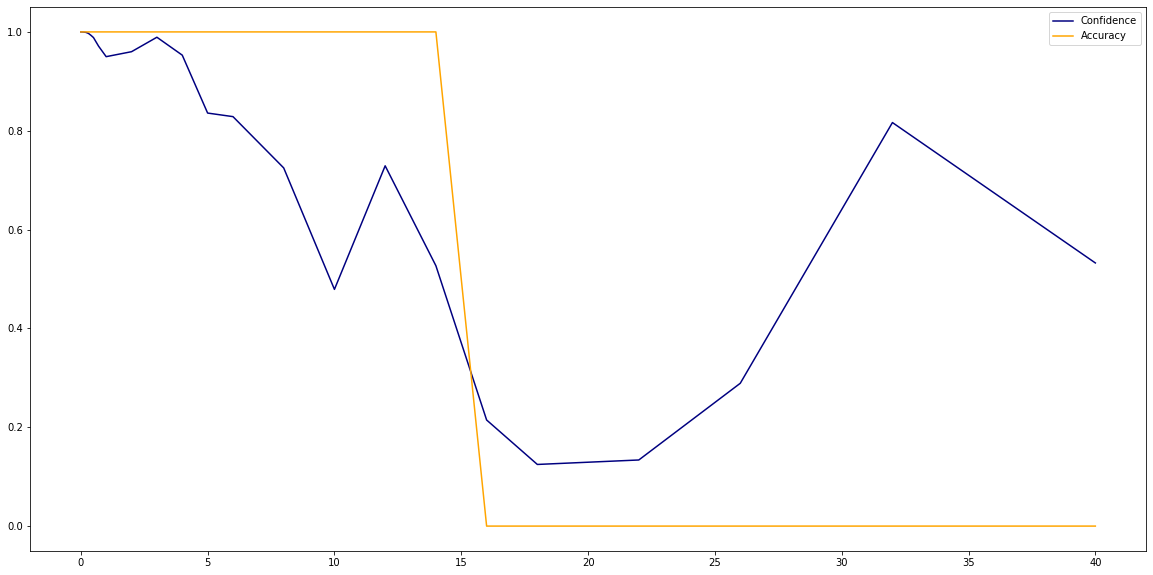

In [98]:
iterate_epsilons(766)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997663	barrel, cask
0.2			1	0.9991203	barrel, cask
0.3			1	0.9973918	barrel, cask
0.4			1	0.9938798	barrel, cask
0.5			1	0.98826796	barrel, cask
0.7			1	0.95988446	barrel, cask
1.0			1	0.9368711	barrel, cask
2.0			1	0.85285	barrel, cask
3.0			1	0.42362154	barrel, cask
4.0			1	0.32486832	barrel, cask
5.0			1	0.587586	barrel, cask
6.0			1	0.23409425	barrel, cask
8.0			0	0.093663804	lumbermill, sawmill
10.0			0	0.10282399	lumbermill, sawmill
12.0			0	0.21646465	lumbermill, sawmill
14.0			0	0.098761804	lumbermill, sawmill
16.0			0	0.17943078	lumbermill, sawmill
18.0			0	0.10978956	lumbermill, sawmill
22.0			0	0.14064844	boa constrictor, Constrictor constrictor
26.0			0	0.14764187	honeycomb
32.0			0	0.8395479	honeycomb
40.0			0	0.094081685	tarantula


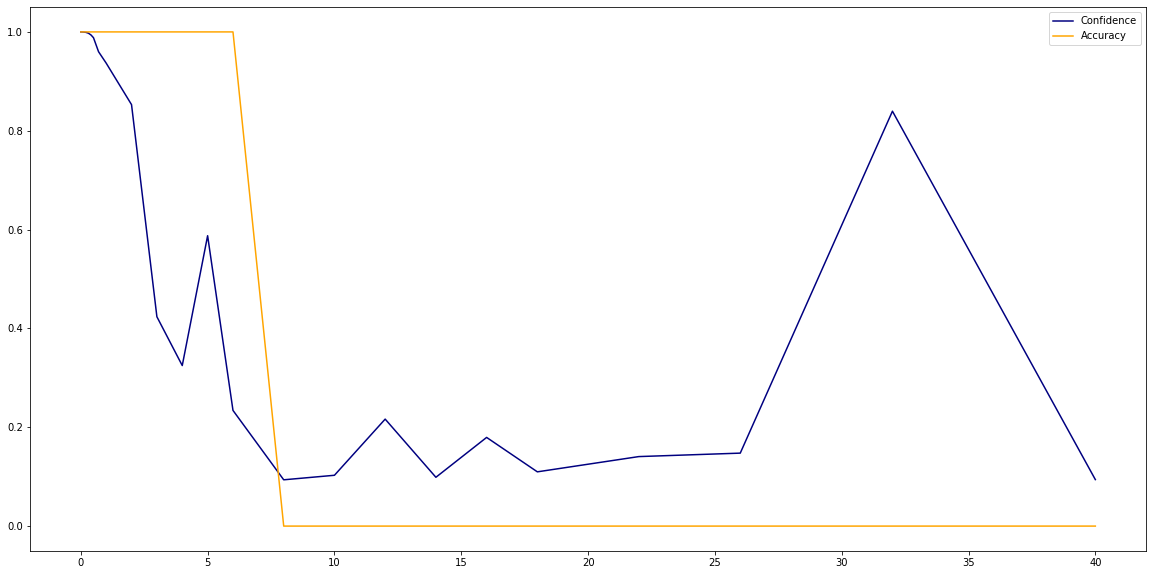

In [102]:
iterate_epsilons(766)

Epsilon 	 Accuracy 	 Confidence 	 Label
2.5500000000000003			1	0.58938587	dial telephone, dial phone
0.1			1	0.9988556	dial telephone, dial phone
0.2			1	0.9970053	dial telephone, dial phone
0.3			1	0.9936346	dial telephone, dial phone
0.4			1	0.9883478	dial telephone, dial phone
0.5			1	0.9809203	dial telephone, dial phone
0.7			1	0.959067	dial telephone, dial phone
1.0			1	0.90892076	dial telephone, dial phone
2.0			1	0.6984587	dial telephone, dial phone
3.0			1	0.52429956	dial telephone, dial phone
4.0			1	0.4055124	dial telephone, dial phone
5.0			1	0.35374087	dial telephone, dial phone
6.0			1	0.35036153	dial telephone, dial phone
8.0			1	0.33643234	dial telephone, dial phone
10.0			1	0.30700144	dial telephone, dial phone
12.0			0	0.2909409	spindle
14.0			0	0.32932037	spindle
16.0			0	0.27878878	spindle
18.0			0	0.20404696	spindle
22.0			0	0.14253508	spindle
26.0			0	0.09459376	spindle
32.0			0	0.04435969	spindle
40.0			0	0.02793514	scorpion


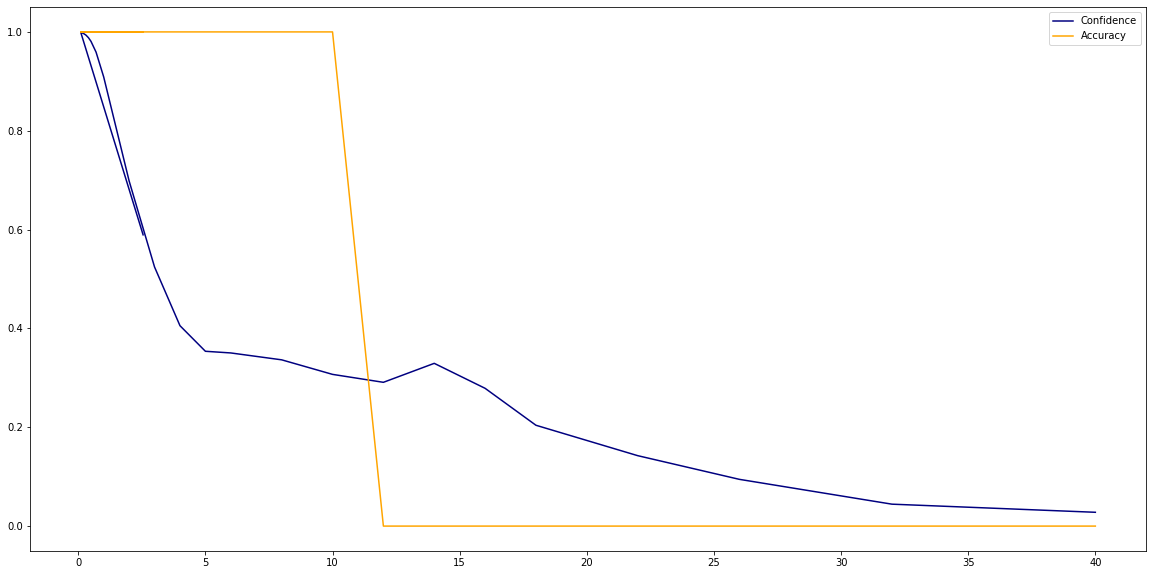

In [47]:
iterate_epsilons(590)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9984958	honeycomb
0.1			1	0.99721515	honeycomb
0.2			1	0.9936559	honeycomb
0.3			1	0.98548675	honeycomb
0.4			1	0.9702776	honeycomb
0.5			1	0.94641435	honeycomb
0.7			1	0.87577116	honeycomb
1.0			1	0.7662984	honeycomb
2.0			1	0.6421063	honeycomb
3.0			1	0.6387259	honeycomb
4.0			1	0.63160247	honeycomb
5.0			1	0.64614445	honeycomb
6.0			1	0.68201077	honeycomb
8.0			1	0.80579555	honeycomb
10.0			1	0.9198083	honeycomb
12.0			1	0.9653693	honeycomb
14.0			1	0.9822119	honeycomb
16.0			1	0.9883703	honeycomb
18.0			1	0.99088913	honeycomb
22.0			1	0.99439573	honeycomb
26.0			1	0.99641454	honeycomb
32.0			1	0.99756575	honeycomb
40.0			1	0.997715	honeycomb


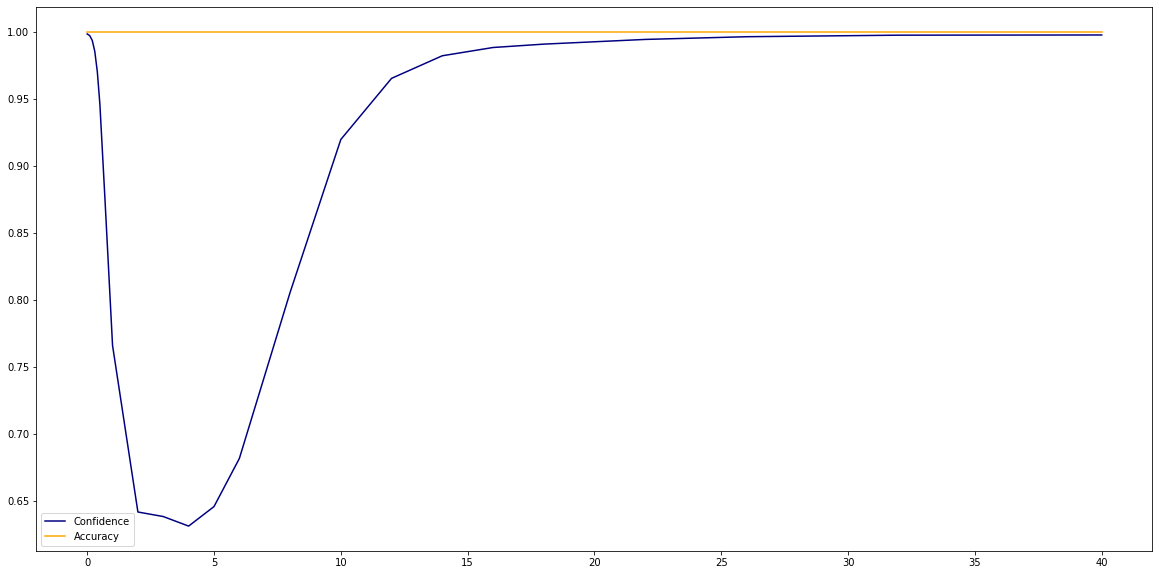

In [75]:
iterate_epsilons(132)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9978678	baseball
0.1			1	0.99073595	baseball
0.2			1	0.9740122	baseball
0.3			1	0.9442655	baseball
0.4			1	0.8999622	baseball
0.5			1	0.8442669	baseball
0.7			1	0.726144	baseball
1.0			1	0.58897096	baseball
2.0			1	0.35198572	baseball
3.0			1	0.24360058	baseball
4.0			1	0.18754263	baseball
5.0			1	0.15972885	baseball
6.0			1	0.14501931	baseball
8.0			1	0.11653368	baseball
10.0			1	0.13254663	baseball
12.0			1	0.16315761	baseball
14.0			1	0.19640179	baseball
16.0			1	0.2417866	baseball
18.0			1	0.2595709	baseball
22.0			1	0.2806484	baseball
26.0			1	0.24594808	baseball
32.0			1	0.18234633	baseball
40.0			0	0.21733066	poncho


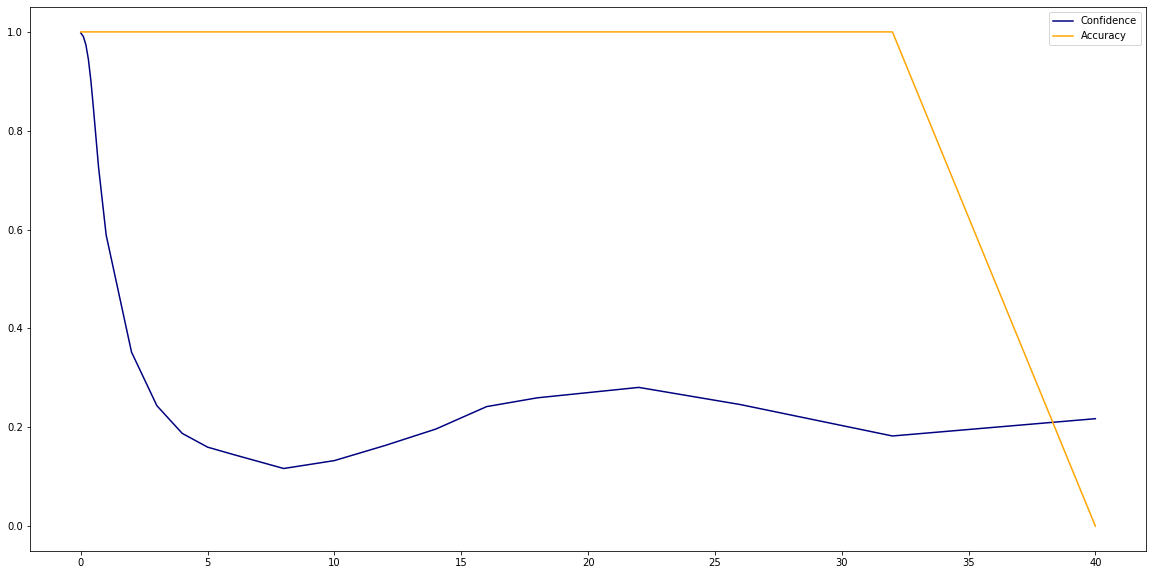

In [76]:
iterate_epsilons(241)

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

In [ ]:
# Set hyperparameter
epsilons = [0, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]
alpha = 1 # As in the paper


# Initialize lists
num_iter = []
accurcy_top1 = []
accurcy_top5 = []
confidence_adversarial = []


for epsilon in epsilons:
   
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    num_iter.append(num_iterations)
    
    acc_sub_adver_top1 = []
    acc_sub_adver_top5 = []
    conf_sub_adver = []
    i = 1
    
    for image_clean, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon*255))
        print("Sample: " + str(i))
        print("Number of iterations: " + str(num_iterations))
        print("Average adv. accuracy: {:.2f}\nAverage adv. confidence: {:.2f}".format(np.mean(acc_sub_adver_top1), np.mean(np.mean(conf_sub_adver) )) )
        
        # Predict with clean image
        _, corr, _, conf, _ = predict(model, image_clean, label)

        # Generate adversarial example only if initial prediction was correct
        if corr == 1:
            # Predict with adversarial image
            image_adversarial = apply_BIM(model, image_clean, label, alpha, epsilon, num_iterations=num_iterations)
            _, top1, top5, conf, _ = predict(model, image_adversarial, label)
            acc_sub_adver_top1.append(top1)
            acc_sub_adver_top5.append(top5)
            conf_sub_adver.append(conf)
            
        else:
            acc_sub_adver_top1.append(0)
            acc_sub_adver_top5.append(0)
            conf_sub_adver.append(0)
            
        i += 1

    # Add accuracies and confidences
    accurcy_top1.append(np.mean(acc_sub_adver_top1))
    accurcy_top5.append(np.mean(acc_sub_adver_top5))
    confidence_adversarial.append(np.mean(conf_sub_adver))


# Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Num_Iter"] = num_iter
result["Accuracy Top 1"] = accurcy_top1
result["Accuracy Top 5"] = accurcy_top5
result["Confidence"] = confidence_adversarial
result.to_csv("results/googleNet_ImageNet_BIM_2.csv")

## 3. Discussion

In [9]:
# Load results
result = pd.read_csv("results/googleNet_ImageNet_BIM.csv")
accurcy_top1 = result["Accuracy Top 1"]
accurcy_top5 = result["Accuracy Top 5"]
confidence_adversarial = result["Confidence"]
epsilon = result["Epsilon_255"]

KeyError: 'Accuracy Top 1'

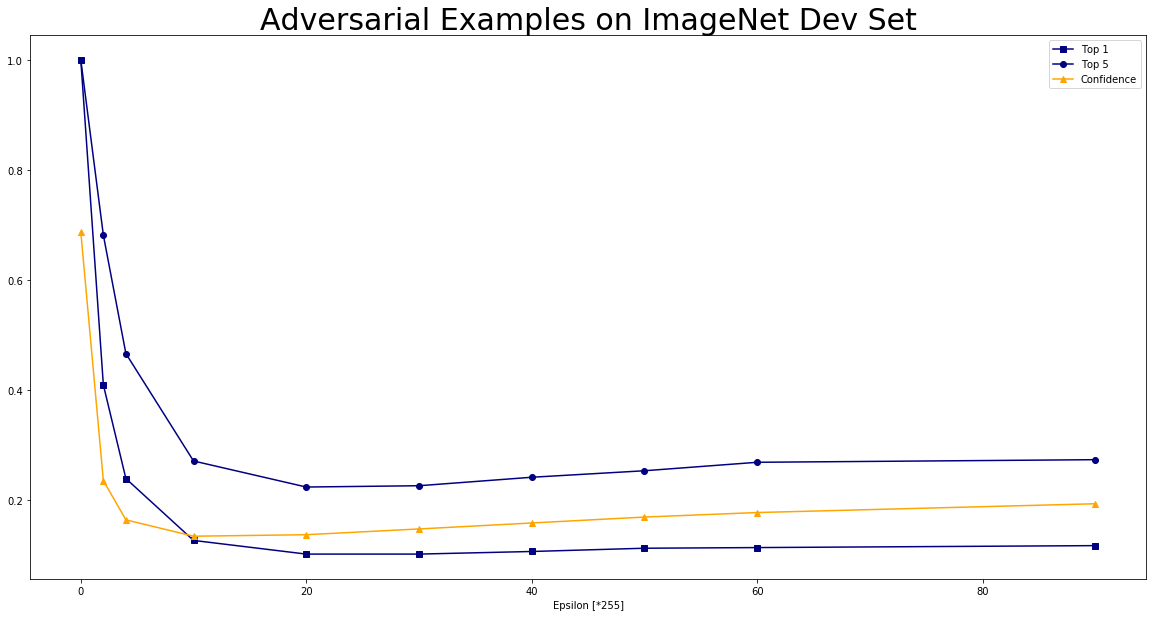

In [12]:
# Plot
plt.plot(e, accurcy_top1, "s-", color="navy", label="Top 1")
plt.plot(e, accurcy_top5, "o-", color="navy", label="Top 5")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples from BIM on ImageNet", fontsize=30)
plt.legend()
plt.show()

#plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_BIM2.pdf")
#plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_BIM2.png")

Some text ...

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*